# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*Never let them guess your next move.*' has the following 3-grams:

* 'never let them'
* 'let them guess'
* 'them guess your'
* 'guess your next'
* 'your next move'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Josip Hanak</font>

E-mail: <font color="blue">josip.hanak@fer.hr</font>

Date: <font color="blue">14/10/2022</font>

# 0. Dataset

The corpus you will use contains about 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). Python's JSON library takes care of translating it into a dictionary.

Then, the file is compressed using `gzip`, and can be compressed with the `gunzip` command, although we will read it in compressed form. The file is named `CovidLockdownCatalonia.json.gz`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [231]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [232]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

Implement the Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union.

You can use set operations: `set(l)` to convert a list `l` to a set, then `set1.union(set2)` and `set1.intersection(set2)` to compute union and intersection of sets `set1`, `set2`. Learn more in this [tutorial on set operations](https://learnpython.com/blog/python-set-operations/)

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [233]:
def jaccard_similarity(x, y):
    set1 = set(x)
    set2 = set(y)
    union = set1.union(set2)
    intersect = set1.intersection(set2)
    if len(union)>0:
        return len(intersect)/len(union)
    else: 
        return 0

Write code to test your function. Your tests cases should be:

1. Two arrays for which the jaccard similarity is 0.6666...
1. Two arrays for which the jaccard similarity is 0.75
1. Two arrays for which the jaccard similarity is 1.0
1. Two empty arrays should have jaccard similarity 0.0

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [234]:
listA = ["i", "love", "data"]
listB = ["love", "data", "i"]
print(jaccard_similarity(listA, listB))
listC = ["i", "love", "data", "not"]
print(jaccard_similarity(listA, listC))
listD = ["everything", "said", "has", "been", "lie"]
print(jaccard_similarity(listA, listD))
listE = ["lie", "has", "been", "normal", "everything"]
print(jaccard_similarity(listD, listE))

1.0
0.75
0.0
0.6666666666666666


Implement a function `clean` that cleans-up text according to this specification:

1. Removing "RT " prefixes
1. Converting to lowercase
1. [Romanizing](https://en.wikipedia.org/wiki/Romanization) text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.
1. Removing URLs, both "http" and "https" ones.
1. Removing spaces at the beginning and spaces at the end with the `strip()` function.
1. Removing anything that remains that is not a letter or digit
1. Changing double spaces to single spaces.

You can use `text.lower()` to convert to lowercase, and then `re.sub(...)` to replace parts of the text. See [Python regexps](https://docs.python.org/3/library/re.html).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [255]:
import unidecode
def clean(text):
    if text.startswith("RT"):
        text =  text[2:]
    text = unicode(text)
    text = text.lower().strip()
    text = text.replace("http","")
    text = text.replace("https","")
    text = re.sub(' +', ' ',text) 
    text = re.sub(r'[^a-zA-Z0-9 ]+', '', text)
    return text
    

Test your function by passing it five different texts including punctuation, non-Roman characters, URLs, etc. Make sure your test cases cover all the required aspects of the specification.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [236]:
#testing lowercase
text = clean("BabaMISaTamRT")
print(text)
#testing RT prefix
text = clean("RTa is a  RTb")
print(text)
#testing http and https
text = clean("http//alfahttp and https//beta")
print(text)
#testing non roman literals

#testing non digit or letter literals
text = clean("!!ajme meni, RT majko moj=?!a")
print(text)

babamisatamrt
a is a rtb
alfa and sbeta
ajme meni rt majko moja


# 2. Implement an n-gram extractor

Implement the function `ngrams(text,size)`, which should produce all sub-sequences of `size` words present in the text. Use the following skeleton:

```python
MIN_TOKEN_LENGTH = 2

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    # your code here
    return ngrams
```

Note that `ngrams` is a list, and each element of a list is a *string*.

The only words you must consider in a ngram are words having at least `MIN_TOKEN_LENGTH` characters.

You can use the [split](https://docs.python.org/2/library/string.html#string.split) and [join](https://docs.python.org/2/library/string.html#string.join) function of the split library. Remember that to extract elements *i* to *j* of array *a* you use `a[i:j]`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [109]:
MIN_TOKEN_LENGTH = 2
def ngrams(text, size):
    tokens = clean(text).split()
    tokens = [item for item in tokens if len(item) >= 2]
    ngrams = []
    for i in range(len(tokens)-size):
        j = i+size
        ngram = []
        ngram = tokens[i:j]
        ngram = ' '.join(ngram)
        ngrams.append(ngram)
    return ngrams


Test your function:

```python
print(messages[9780])
print(ngrams(messages[9780], 2))
```

Should print:

```
RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']
```

Remember that `ngrams` should return a list of string, not a list of lists, so carefully check that you are returning a list of strings and not a list of lists.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [110]:
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antisptic', 'antisptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

The following code, which you should leave as-is, computes the time it takes to compare all first *limit* messages against all first *limit* messages in the array.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [82]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Use the function above to create a plot in which you have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size 3. Try with x from *1* to *2001* in increments of *150* (use the [range](https://docs.python.org/3/library/functions.html#func-range) function).

In this plot, remember to include labels in both axes.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to label the x and y axis.</font>

In [93]:
message_num_time = dict()
for num_messages in range(1,2001,150):
    message_num_time[num_messages] = time_brute_force_similarities(messages, num_messages, 3)
    print(time_brute_force_similarities(messages, num_messages, 3))
print(message_num_time)

9.980006143450737e-05
0.6774516999721527
2.7850711001083255
6.087803700007498
10.544664799934253
17.651897500036284
25.233208799967542
34.50250809988938
44.802438700105995
55.25425019999966
71.55880200001411
89.65524969995022
99.09163440018892
115.63906170008704
{1: 0.0001970999874174595, 151: 0.6127774999476969, 301: 2.7442266999278218, 451: 6.02620070008561, 601: 10.73564779991284, 751: 17.09892479982227, 901: 26.333338900003582, 1051: 34.56404000008479, 1201: 45.556621899828315, 1351: 57.69637449993752, 1501: 69.5631135001313, 1651: 89.3131572001148, 1801: 104.69473390001804, 1951: 114.7669877000153}


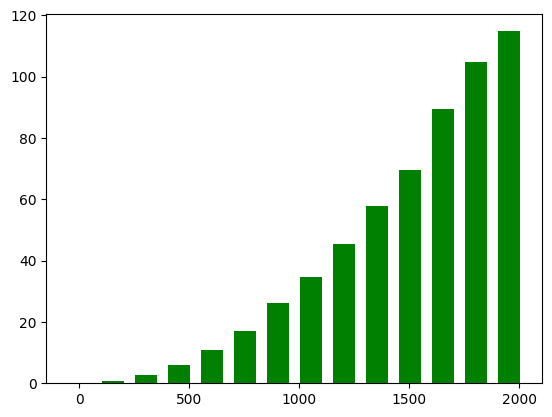

In [97]:
plt.bar(list(message_num_time.keys()), message_num_time.values(), width=100, color='g')
plt.show()

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>

In [ ]:
If the data set contains 10000 messages (documents) that is 5 times the size of what is given to the algorithm 
(which takes around 2 minutes to complete). As shown in the graph the time increases in a way similar to a quadratic function 
(taking 150 messages difference as x values). The difference between the whole dataset and the previously calculated dataset 
is 53 bins of 150 messages. I would approximate that for the whole dataset it would take 3574 seconds which is 0.99 of an hour
 




# 4. Computing the doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

In real-world implementations, this is done by hashing the ngrams and then every row is an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 4.1 Create list of all ngrams

Implement code to create:

* the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number),
* the dictionary `index_to_ngram`, which should convert an index to an ngram, and
* the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

You can use the following template:

```python
NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
```

Note that the total number of n-grams may vary depending on ho you `clean()` text. In this dataset it should be about 10 times the number of documents.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [129]:
NGRAM_SIZE = 3

ngram_to_index = dict()
index_to_ngram = dict()
index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index.keys():
            ngram_to_index[ngram] = index
            index_to_ngram[index] = ngram
            index=index+1
        

num_distinct_ngrams = index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 63948 distinct ngrams in the 10000 documents


Test your function by printing the `ngram_to_index` of the strings `"tancat escoles fins"` and `"garantir la seguretat"`. The exact index varies,  depending on how you `clean()` text. Then, print the `index_to_ngram` of the returned index, and should give you the same string.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [119]:
print(ngram_to_index["garantir la seguretat"], ngram_to_index["tancat escoles fins"])
print(index_to_ngram[ngram_to_index["tancat escoles fins"]], index_to_ngram[ngram_to_index["garantir la seguretat"]])

33 888
tancat escoles fins garantir la seguretat


## 2.2 Create table ngrams x documents

Now we will create a boolean matrix named `M_ngram_doc`, where each row should be an n-gram, and each column should be a document.

There might be documents having less than *NGRAM_SIZE* words and thus containing no shingles. You can skip those documents above (when reading the file), or handle them here.

The next code creates an empty matrix. Leave as-is. If you run out of memory, limit the number of documents you read at the beginning of this file, for instance, read only the first 10,000 or the first 7,000 documents, and then try again.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [130]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 63948 rows (distinct shingles) x 10000 columns (distinct documents)


Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a `True` if document j contains ngram i, otherwise holds `False`.

You can use the following template:

```python
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [134]:
NGRAM_SIZE = 3
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        M_ngram_doc[ngram_to_index[ngram]][docid] = True


Measure the density of this matrix, as a percentage. This is the number of non-zeroes in the matrix as a percentage of the number of cells of the matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage.</font>

In [142]:
shape = M_ngram_doc.shape
size = shape[0]*shape[1]
density = (np.count_nonzero(M_ngram_doc)/size)*100
print(density)

0.023062488271720773


Print a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes. For instance, for docid 9602 you should print something like this:

```
Positions of non-zeros in column of docid 9602 of M_ngram_doc

Clean message:
 emergenciescat que puc fer i que no faqs del coronavirus a 14 de mar si us plau demanem difusioNon-zeros in corresponding row:
 emergenciescat que puc fer i que no faqs del coronavirus a 14 de mar si us plau demanem difusio
 
Non-zeros in corresponding row:
 ['911 (si us plau)', '1222 (emergenciescat que puc)', '1223 (que puc fer)', '1224 (puc fer que)', '1225 (fer que no)', '2575 (14 de mar)', '39134 (que no faqs)', '39135 (no faqs del)', '39136 (faqs del coronavirus)', '39137 (del coronavirus 14)', '39138 (coronavirus 14 de)', '39139 (de mar si)', '39140 (mar si us)', '39141 (us plau demanem)', '39142 (plau demanem difusio)']
 ```

Note that the specific ngram ids you will get depend on your cleanup process, and that the output is in ascending order of ngram number, not in the same ordering in which the ngrams appear in the message.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [205]:

indexes1 = np.array(np.nonzero(M_ngram_doc[:,9602]))
indexes2 = np.array(np.nonzero(M_ngram_doc[:,941]))
#print(indexes1[0])
#print(indexes2[0])
for index in indexes1[0]:
    print(index, "(", index_to_ngram[index], ")")
print()
for index in indexes2[0]:
    print(index, "(", index_to_ngram[index], ")")
print(messages[941])

861 ( si us plau )
1161 ( emergenciescat qu puc )
1162 ( qu puc fer )
2448 ( 14 de mar )
24227 ( fer que no )
37368 ( puc fer que )
37369 ( que no faqs )
37370 ( no faqs del )
37371 ( faqs del coronavirus )
37372 ( del coronavirus 14 )
37373 ( coronavirus 14 de )
37374 ( de mar si )
37375 ( mar si us )
37376 ( us plau demanem )
37377 ( plau demanem difusi )

1403 ( usem de forma )
1404 ( de forma responsable )
1405 ( forma responsable els )
1406 ( responsable els recursos )
1407 ( els recursos sanitaris061 )
1408 ( recursos sanitaris061 urgncies )
1409 ( sanitaris061 urgncies per )
1410 ( urgncies per coronavirus )
1411 ( per coronavirus sanitries012 )
1412 ( coronavirus sanitries012 consultes )
9738 ( hospiolot usem de )
RT @hospiolot: ❕Usem de forma responsable els recursos sanitaris:

📞061➡️ Urgències per #coronavirus i sanitàries

📞012➡️ Consultes general…


# 3. Implement a permutation generator

Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function [random.shuffle](https://docs.python.org/3/library/random.html#random.shuffle) might be useful. If you want to use `range(...)`, which returns an iterator, you will need to convert the iterator to a list by using `list(range(...))`.

Remember to test your code. For instance, a permutation of 20 elements should look like this:

```
[14, 10, 0, 8, 4, 12, 5, 19, 6, 9, 15, 13, 16, 2, 17, 11, 7, 3, 18, 1]
```

Every number appears only once, and all numbers from 0 to 19 appear in the permutation.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [216]:
def random_permutation(k):
    mylist = list(range(0,k))
    random.shuffle(mylist)
    fin = list(mylist)
    return fin

print(random_permutation(6))

[0, 2, 3, 1, 5, 4]


Further test this by applying the same permutation on two lists. The code below, which you must leave as-is,  should print both lists in the same ordering, so that *alpha* is in the same position of *a*, *beta* in the same position as *b*, and so on.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [256]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (ek)", "2 (do)", "3 (tīn)", "4 (chār)", "5 (pāṅc)"]
original_list_2 = ["1 (jedan)", "2 (dva)", "3 (tri)", "4 (četiri)", "5 (pet)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['1 (ek)', '2 (do)', '5 (pāṅc)', '3 (tīn)', '4 (chār)']
['1 (jedan)', '2 (dva)', '5 (pet)', '3 (tri)', '4 (četiri)']

Test another permutation
['4 (chār)', '2 (do)', '3 (tīn)', '5 (pāṅc)', '1 (ek)']
['4 (četiri)', '2 (dva)', '3 (tri)', '5 (pet)', '1 (jedan)']


# 4. Compute the signature of each document

Now comes the core of the algorithm. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [230]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    #permutations.append(random_permutation(num_distinct_ngrams))
    permutations.append(permutation)
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

63948
Permutation 0: 17892, 28993, 27511, ...
63948
Permutation 1: 27740, 3456, 20882, ...
63948
Permutation 2: 18002, 32798, 51975, ...
63948
Permutation 3: 50038, 10127, 46791, ...
63948
Permutation 4: 42474, 51397, 839, ...


Now, you implement the signature construction. The matrix `M_signature_doc` should contain in row *i*, column *j*, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

This process may take a few minutes to be completed. You can use the following template:

```python
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [237]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace with code
        M_signature_doc[permutation_num][docid]=find_first_one(docid,permutation)

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

Test your code by checking the signatures of two documents that are near-duplicates,using the next code, which you should leave as-is. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

Note that your ngrams and signatures vectors might be different than what we show here, given the differences in cleaning procedures and the randomness of the permutations.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [238]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, i] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat  el govern de la gencat anuncia el confinament de tot catalunyadavant lemergncia de la covid19 el missatge s clau
Ngrams        : [57, 3179, 3295, 3896, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666]
Signature     : [4657.0, 3295.0, 4657.0, 57.0, 4658.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergncia de la covid19 el missatge s clau limitar la mobilitat ajudar a evitar la propagaci del coronavirus evi

# 5. Compare all pairs of signatures

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least 50 signature matches, considering both full matches and partial matches.</font>

In [248]:
#Now we are ready to compare all documents by their signatures, instead of by their content.

#We will consider that if two documents have similarity == 1.0 they are a full signature match, and if two documents have 0.2 < similarity < 1.0 they are a partial signature match. In both cases, this may mean the documents are duplicates or near duplicates.

#Write code to compare all pairs of documents. Use the following template:

is_possible_duplicate = {}
saved = 0
# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                if jaccard_similarity(signature1,signature2) == 1.0:
                    is_possible_duplicate[docid1] = docid2
                    count_sig_full_matches = count_sig_full_matches +1
                elif jaccard_similarity(signature1,signature2) >0.2 and jaccard_similarity(signature1,signature2) <1.0:
                    is_possible_duplicate[docid1] = docid2
                    count_sig_partial_matches = count_sig_partial_matches + 1
                    
                if count_sig_partial_matches == 55:
                    saved == docid2
                # REPLACE THIS COMMENT WITH YOUR CODE:
                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed

        # REPLACE THIS COMMENT WITH YOUR CODE
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
        num_match = count_sig_full_matches + count_sig_partial_matches
        if num_match >= 50:
            print(docid1,"   full matches:", count_sig_full_matches, "    partial matches:", count_sig_partial_matches)

0/10000 documents scanned
16    full matches: 89     partial matches: 2
20    full matches: 28     partial matches: 55
42    full matches: 46     partial matches: 6
53    full matches: 57     partial matches: 0
84    full matches: 88     partial matches: 2
85    full matches: 45     partial matches: 6
128    full matches: 44     partial matches: 6
166    full matches: 56     partial matches: 0
167    full matches: 55     partial matches: 0
168    full matches: 54     partial matches: 0
172    full matches: 53     partial matches: 0
174    full matches: 52     partial matches: 0
176    full matches: 51     partial matches: 0
268    full matches: 50     partial matches: 0
307    full matches: 87     partial matches: 2
328    full matches: 65     partial matches: 0
331    full matches: 64     partial matches: 0
394    full matches: 27     partial matches: 52
412    full matches: 63     partial matches: 0
425    full matches: 86     partial matches: 2
448    full matches: 62     partial ma

5733    full matches: 76     partial matches: 0
5740    full matches: 75     partial matches: 0
5751    full matches: 146     partial matches: 0
5762    full matches: 74     partial matches: 0
5784    full matches: 145     partial matches: 0
5787    full matches: 144     partial matches: 0
5818    full matches: 59     partial matches: 0
5822    full matches: 143     partial matches: 0
5858    full matches: 142     partial matches: 0
5885    full matches: 141     partial matches: 0
5891    full matches: 140     partial matches: 0
5892    full matches: 139     partial matches: 0
5901    full matches: 138     partial matches: 0
5902    full matches: 137     partial matches: 0
5917    full matches: 136     partial matches: 0
5918    full matches: 58     partial matches: 0
5957    full matches: 57     partial matches: 0
5960    full matches: 56     partial matches: 0
5968    full matches: 73     partial matches: 0
5998    full matches: 55     partial matches: 0
6000/10000 documents scanned


<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

In [249]:
print(messages[5077])

RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK


In [ ]:
This is a public concern message regarding the corona virus pandemic which reasonably attracted attention.

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

In [252]:
print(messages[20])

RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇

🔗 https://t.co/NS41dWDi9O ht…


# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, compare what happens with 3 different ngram sizes (2-grams, 3-grams, 4-grams) in terms of the efficiency (speed) and effectiveness (accuracy). You can include plots for efficiency, and examples for effectiveness.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: various ngram sizes</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>